In [1]:
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
from matplotlib.colors import LinearSegmentedColormap

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
plt.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
plt.rcParams.update({'figure.figsize': [13,5]}) # Set the standard figure size.

In [59]:
nc_file = nc.Dataset("D93_sp.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
ps_mean = np.mean(nc_file.variables["sp"][:,:,:], axis=0)
nc_file.close()

nc_file = nc.Dataset("geopotential.nc", "r")
Phi_s = nc_file.variables["z"][0,:,:]
nc_file.close()

nc_file = nc.Dataset("D93_stress.nc", "r")
ewss_mean = np.mean(nc_file.variables["ewss"][:,:,:], axis=0) / 86400.
lgws_mean = np.mean(nc_file.variables["lgws"][:,:,:], axis=0) / 86400.
nc_file.close()

In [67]:
# Function for surface integral
def calc_surface_integral(var):
    dlat_rad = np.deg2rad(abs(lat[1]-lat[0]))
    dlon_rad = np.deg2rad(abs(lon[1]-lon[0]))
    
    # No time dimension.
    if (var.ndim == 2):
        zonal_integral = a * np.sum(dlon_rad * cos_lat[:,np.newaxis] * var, axis=-1)
        total_integral = a * np.sum(dlat_rad * zonal_integral)
    # Time dimension.
    elif (var.ndim == 3):
        zonal_integral = a * np.sum(dlon_rad * cos_lat[:,np.newaxis] * var, axis=-1)
        total_integral = a * np.sum(dlat_rad * zonal_integral, axis=-1)     
    
    return zonal_integral, total_integral

# Calculate the torques.
a = 6367470.
g = 9.81
cos_lat = np.cos(np.deg2rad(lat))

k = np.arange(0, lon.size//2+1)
dPsi_s_dlambda = np.fft.irfft(1j * k * np.fft.rfft(Phi_s, axis=1))
T_m = - ps_mean / g * dPsi_s_dlambda

T_m_zonal, T_m_sphere = calc_surface_integral(T_m)

#T_m_time = - ps / g * dPsi_s_dlambda
#T_m_zonal_time, T_m_sphere_time = calc_surface_integral(T_m_time)
#T_m_sphere2 = T_m_sphere_time.mean()
#T_m_zonal2 = T_m_zonal_time.mean(axis=0)

ewss_torque = -a * cos_lat[:,np.newaxis] * ewss_mean
lgws_torque = -a * cos_lat[:,np.newaxis] * lgws_mean

ewss_zonal, ewss_sphere = calc_surface_integral(ewss_torque)
lgws_zonal, lgws_sphere = calc_surface_integral(lgws_torque)

total_zonal = ewss_zonal + lgws_zonal + T_m_zonal
total_sphere = ewss_sphere + lgws_sphere + T_m_sphere

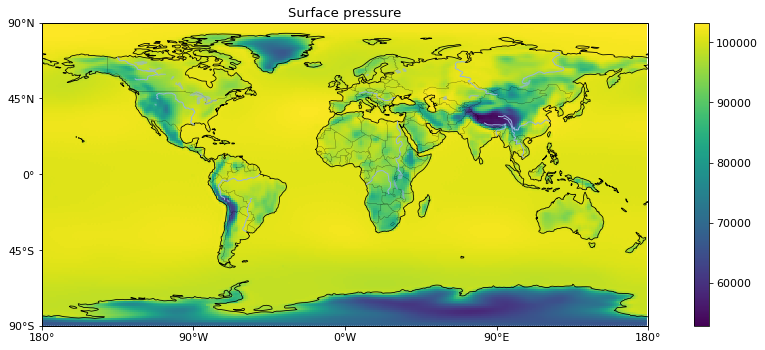

In [68]:
my_projection = ccrs.PlateCarree(central_longitude=0)

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.set_global()

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax1.add_feature(cartopy.feature.RIVERS)

ax1.set_xticks(np.linspace(-180, 180, 5), crs=my_projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.pcolormesh(lon, lat, ps_mean)
plt.colorbar(cb)
plt.title('Surface pressure')
plt.tight_layout()

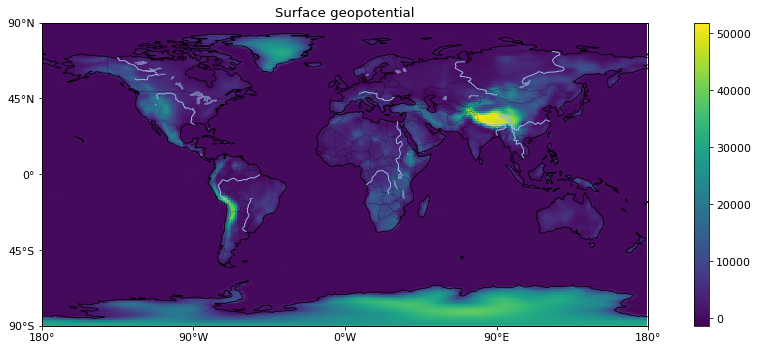

In [69]:
my_projection = ccrs.PlateCarree(central_longitude=0)

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.set_global()

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax1.add_feature(cartopy.feature.RIVERS)

ax1.set_xticks(np.linspace(-180, 180, 5), crs=my_projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

cb = ax1.pcolormesh(lon, lat, Phi_s)
plt.colorbar(cb)
plt.title('Surface geopotential')
plt.tight_layout()

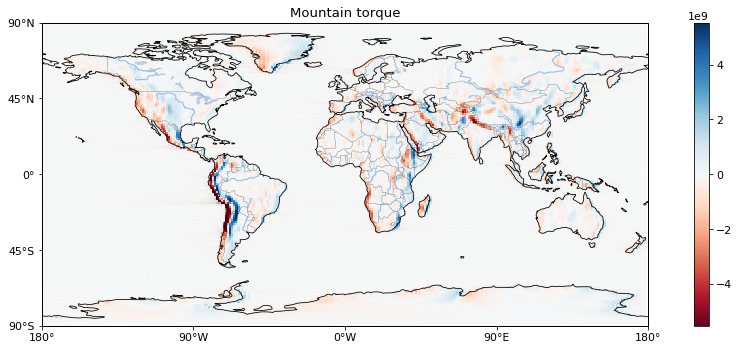

In [82]:
my_projection = ccrs.PlateCarree(central_longitude=0)

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.set_global()

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax1.add_feature(cartopy.feature.RIVERS)

ax1.set_xticks(np.linspace(-180, 180, 5), crs=my_projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

vrange = 0.6*max(abs(T_m.min()), T_m.max())
cb = ax1.pcolormesh(lon, lat, T_m, cmap=plt.cm.RdBu, vmin=-vrange, vmax=vrange)
plt.colorbar(cb)
plt.title('Mountain torque')
plt.tight_layout()

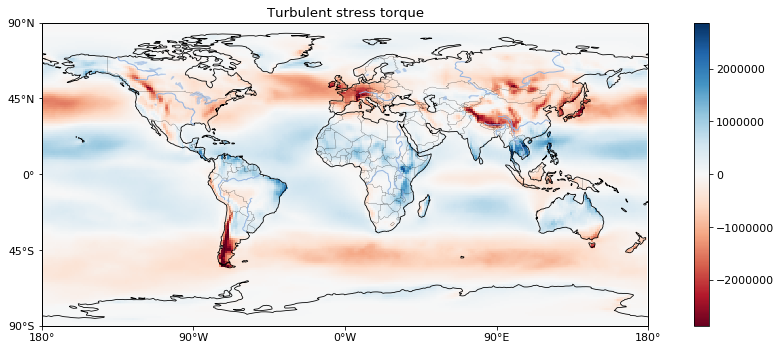

In [80]:
my_projection = ccrs.PlateCarree(central_longitude=0)

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.set_global()

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax1.add_feature(cartopy.feature.RIVERS)

ax1.set_xticks(np.linspace(-180, 180, 5), crs=my_projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

vrange = 0.6*max(abs(ewss_torque.min()), ewss_torque.max())
cb = ax1.pcolormesh(lon, lat, ewss_torque, cmap=plt.cm.RdBu, vmin=-vrange, vmax=vrange)
plt.colorbar(cb)
plt.title('Turbulent stress torque')
plt.tight_layout()

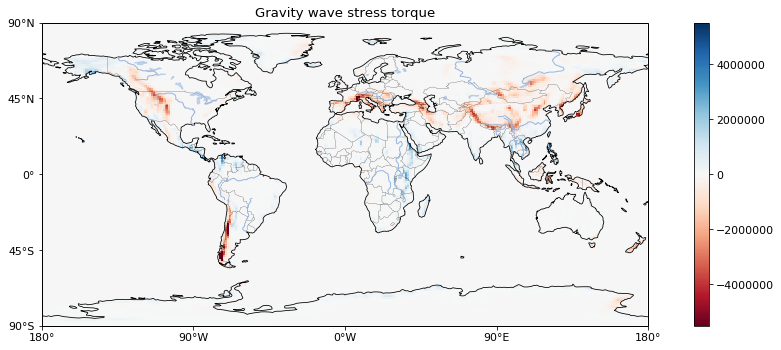

In [81]:
my_projection = ccrs.PlateCarree(central_longitude=0)

fig1 = plt.figure()
ax1 = plt.subplot(111, projection=my_projection)
ax1.set_global()

ax1.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
ax1.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
ax1.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax1.add_feature(cartopy.feature.RIVERS)

ax1.set_xticks(np.linspace(-180, 180, 5), crs=my_projection)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=my_projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

vrange = 0.6*max(abs(lgws_torque.min()), lgws_torque.max())
cb = ax1.pcolormesh(lon, lat, lgws_torque, cmap=plt.cm.RdBu, vmin=-vrange, vmax=vrange)
plt.colorbar(cb)
plt.title('Gravity wave stress torque')
plt.tight_layout()

Mountain torque =  -5.74366196792e+18
Turbulent stress torque =  3.3252401276e+18
Gravity wave stress torque =  -1.17082615077e+19
Total torque =  -1.4126683348e+19


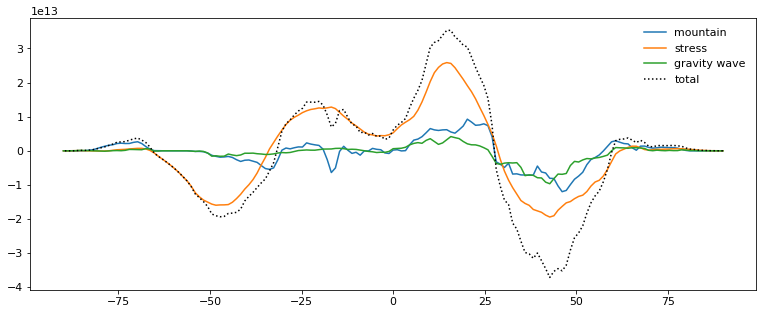

In [76]:
plt.plot(lat, T_m_zonal , label='mountain')
plt.plot(lat, ewss_zonal, label='stress')
plt.plot(lat, lgws_zonal, label='gravity wave')
plt.plot(lat, total_zonal, 'k:', label='total')
plt.legend(loc=0, frameon=False)

print('Mountain torque = ', T_m_sphere)
print('Turbulent stress torque = ', ewss_sphere)
print('Gravity wave stress torque = ', lgws_sphere)
print('Total torque = ', total_sphere)